<a href="https://colab.research.google.com/github/leunco/Hands_On_MachineLearning/blob/main/5%EC%A3%BC%EC%B0%A8/%EA%B9%80%EB%8B%A4%EC%98%81/Chap11_%EC%8B%AC%EC%B8%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D(DNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

## Chap11. 심층 신경망 훈련하기
고해상도 이미지에서 수백 종류의 물체를 감지하는 것처럼 아주 복잡한 문제를 다뤄야 한다면 수백 개의 뉴런으로 구성된 10개 이상의 층을 수십만 개의 가중치로 연결하여 훨씬 더 깊은 심층 신경망을 훈련해야 한다.

심층 신경망을 훈련하는 것은 쉬운 일이 아니며, 훈련 중 다음과 같은 문제를 마주할 수 있다.
- 까다로운 그래디언트 소실 또는 폭주 문제에 직면할 수 있다. 이는 심층 신경망의 아래쪽으로 갈수록 그래디언트가 점점 더 작아지거나 커지는 현상으로, 두 현상 모두 하위층을 훈련하기에 매우 어렵게 만든다.
- 이런 대규모 신경망을 위한 훈련 데이터가 충분하지 않거나 레이블을 만드는 작업에 너무 많은 비용이 든다.
- 훈련이 극단적으로 느려질 수 있다.
- 수백만 개의 파라미터를 가진 모델은 훈련 세트에 과대적합될 위험이 매우 크다. 특히 훈련 샘플이 충분하지 않거나 훈련 세트에 잡음이 많은 경우에 더욱 그렇다.

이 장에서는 이러한 문제들을 차례로 살펴보고 해결 방법을 제시한다.
1. 그래디언트 소실과 폭주 문제를 설명하고, 가장 널리 알려진 해결 방법을 제시한다.
2. 레이블된 데이터가 적은 경우 복잡한 문제를 다루는데 도움이 되는 전이 학습과 비지도 사전 훈련을 알아본다.
3. 대규모 모델의 훈련 속도를 크게 높여주는 다양한 최적화 방법을 알아본다.
4. 대규모 신경망을 위한 규제 기법 중 널리 알려진 몇 가지를 살펴본다.


## 11.1 그래디언트 소실과 폭주 문제
역전파 알고리즘은 출력층에서 입력층으로 오차 그래디언트를 전파하면서 진행된다. 알고리즘이 신경망의 모든 파라미터에 대한 오차 함수의 그래디언트를 계산하면 경사 하강법 단계에서 이 그래디언트를 사용하여 각 파라미터를 업데이트한다.

그러나 알고리즘이 하위층으로 진행될수록 **그래디언트가 점점 작아지는 경우**가 많다. 경사 하강법이 하위층의 연결 가중치를 변경되지 않은 채로 둔다면 **훈련이 좋은 솔루션으로 수렴되기 어렵다.** 이를 **그래디언트 소실**이라고 한다.

반대로 **그래디언트가 점점 커져서 여러 층에서 비정상적으로 큰 가중치로 갱신**되면 **알고리즘이 발산**하게 된다. 이를 **그래디언트 폭주**라고 하며, 주로 순환 신경망에서 나타난다.

일반적으로 **불안정한 그래디언트는 층마다 학습 속도를 달라지게 만들어서** 심층 신경망 훈련을 어렵게 만든다.

그래디언트를 불안정하게 만드는 원인은 많이 사용되는 **로지스틱 시그모이드 활성화 함수**와 가장 인기 있던 **가중치 초기화 방법의 조합** 때문인 것으로 보인다.

이 활성화 함수와 초기화 방식을 사용하면 **각 층에서 출력의 분산이 입력의 분산보다 더 크다**는 것이 밝혀졌다. 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져서 **가장 높은 층에서는 활성화 함수가 0이나 1로 수렴**한다.

아래 그림의 로지스틱 활성화 함수를 보면 입력이 양수나 음수로 커지게 되면 **0이나 1로 수렴하여 기울기가 0에 매우 가까워진다.** 그렇기 때문에 역전파가 될 때 사실상 신경망으로 **전파할 그래디언트가 거의 없고**, **조금 있는 그래디언트는** 최상위층에서부터 역전파가 진행되면서 **점차 약해지게 되어 실제로 아래쪽 층에는 아무것도 도달하지 않게 되는 것**이다.

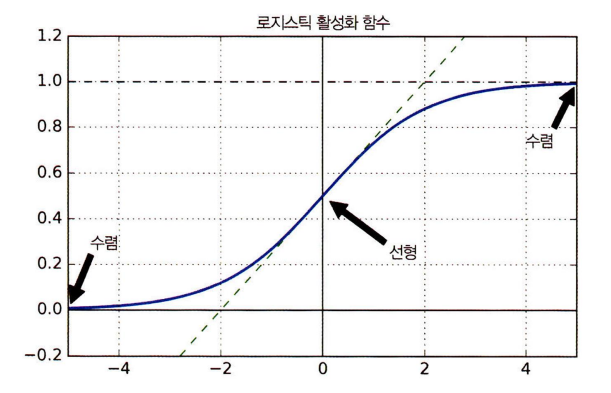

### 11.1.1 글로럿과 He 초기화
적절한 알고리즘은 **예측을 할 때는 정방향**으로, **그래디언트를 역전파할 때는 역방향**으로 양방향 신호가 적절하게 흘러야 한다. 신호가 죽거나 폭주 또는 소멸하지 않아야 한다.

글로럿과 벤지오는 적절한 신호가 흐르기 위해서는 **각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야** 하며, **역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일해야** 한다고 주장한다.

사실 층의 입력 연결 개수(층의 팬-인, fan-in)와 출력 연결 개수(층의 팬-아웃, fan-out)가 같지 않다면 이 2가지를 보장할 수 없다. 그러나 두 사람은 실전에서 매우 잘 작동한다고 입증된 대안을 제안하였는데, 바로 **각 층의 연결 가중치를 무작위로 초기화**하는 것이다. 이 초기화 전략을 글로럿 초기화라고 하며 아래와 같은 식에 따라 진행한다.

> *글로럿 초기화*

평균이 $0$이고 분산이 $\sigma^2=\displaystyle\frac{1}{fan_{avg}}$인 정규분포 또는 $r=\sqrt{\displaystyle\frac{3}{fan_{avg}}}$일 때 $-r$과 $+r$ 사이의 균등분포

단, $fan_{avg}=(fan_{in}+fan_{out})/2$

글로럿 초기화는 현재 딥러닝 성공을 견인한 기술 중 하나로, 이 방식을 사용하면 훈련 속도를 상당히 높일 수 있다.

그 외에도 글로럿 초기화 식에서 $fan_{avg}$를 $fan_{in}$으로 바꾼 르쿤 초기화 방식이 있다. 더 나아가 ReLU 활성화 함수에 대한 초기화 전략을 나타내는 He 초기화 방식도 소개되었다.

아래의 표는 글로럿 초기화, He 초기화, 르쿤 초기화의 사용되는 활성화 함수와 정규분포를 정리한 것이다.

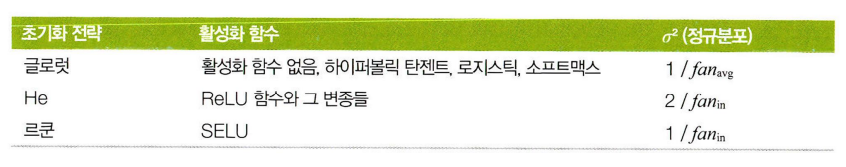

케라스는 기본적으로 **균등분포의 글로럿 초기화**를 사용한다.

`Dense` 층의 **`kernel_initializer`**를 **`'he_uniform','he_normal'`**로 바꾸어서 **He 초기**화를 사용할 수도 있다.

In [2]:
from tensorflow import keras
keras.layers.Dense(10, activation="relu", kernel_initializer='glorot_uniform')

In [3]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

### 11.1.2 수렴하지 않는 활성화 함수
글로럿과 벤지오의 논문에서 얻을 수 있는 통찰 중 하나는 **활성화 함수를 잘못 선택하면 그래디언트의 소실이나 폭주로 이어질 수 있다**는 것이다.

그 전에는 대부분 생물학적 뉴런 방식과 비슷한 시그모이드 활성화 함수가 최선의 선택일 것이라고 생각했으나, **심층 신경망에서 다른 활성화 함수가 훨씬 더 잘 작동한다**는 사실이 밝혀졌다.

특히 ReLU 활성화 함수는 특정 양수값에 수렴하지 않으며 계산이 빠르다는 장점이 있다. 그러나 안타깝게도 ReLU 함수도 완벽하지는 않으며, **죽은 ReLU 문제**가 존재한다. 이는 훈련하는 동안 **일부 뉴런이 0 이외의 값을 출력하지 않는다**는 의미로 붙여진 이름이다. 특히 큰 학습률을 사용하는 경우에는 신경망의 뉴런 절반이 죽어있기도 한다.

뉴런의 가중치가 바뀌어서 훈련 세트에 있는 **모든 샘플에 대하여 입력의 가중치 합이 음수가 되면 뉴런이 죽게 된다.** 즉, **가중치 합이 음수이면 ReLU 활성화 함수의 그래디언트가 0이 되므로** 경사 하강법이 더이상 작동하지 않는다.

이러한 문제를 해결하기 위해 **LeakyReLU** 같은 ReLU 함수의 변종을 사용한다.

이 함수는 $LeakyReLU_{\alpha}(z)=\max(\alpha z,z)$로 정의되며, 함수의 그래프는 아래와 같다.

하이퍼파라미터 **$\alpha$가 이 함수가 새는(leaky) 정도를 결정**한다. 새는 정도란 $z<0$일 때 이 함수의 기울기로, 일반적으로 0.01로 설정한다. 이 **작은 기울기가 LeakyReLU가 절대 죽지 않게 만들어준다.** 뉴런이 혼수 상태에 오래 있을 수는 있더라도 다시 깨어날 가능성을 얻게 되기 때문이다.

아래의 그래프를 보면 LeakyReLU 함수는 ReLU 활성화 함수와 비슷하지만, **$z$가 음수**인 구간에서 **기울기가 0이 아니라 작은 값을 갖는다.**

In [4]:
import numpy as np
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

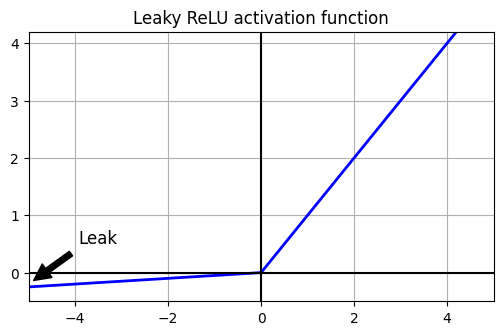

In [5]:
import matplotlib.pyplot as plt
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(6,3.5))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=12, ha="center")
plt.title("Leaky ReLU activation function", fontsize=12)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

툐르크-아크네 클레베레트 등의 논문은 **ELU라는 새로운 활성화 함수**를 제안했다. ELU 활성화 함수는 다른 모든 실험에서 ReLU 변종 함수의 성능을 앞질렀다. 훈련 시간은 감소하면서 신경망의 테스트 세트 성능도 더 높았다.

다음은 ELU 함수의 정의와 그래프를 나타낸 것이다.

> *ELU 활성화 함수*

$ELU_{\alpha}
(z) = \begin{cases} \alpha(\exp(z)-1), &\text{$z<0$ 일 때} \\ z, &\text{$z\geq 0$ 일 때} \end{cases}$

In [6]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

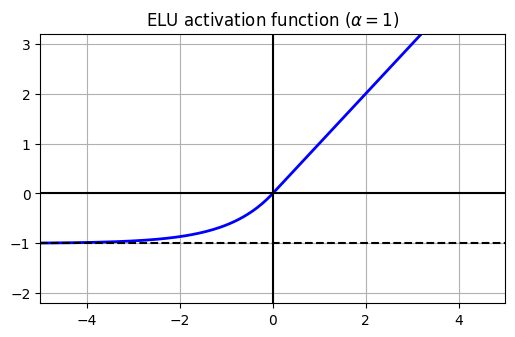

In [7]:
plt.figure(figsize=(6,3.5))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=12)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

ELU 활성화 함수는 몇 가지를 제외하고는 ReLU 활성화 함수와 매우 비슷하다.
- **$z<0$일 때 음수값**이 들어오므로 **활성화 함수의 평균 출력이 0에 더 가까워진다.** 이는 앞서 이야기한 **그래디언트의 소실 문제를 완화**해준다.
- 하이퍼파라미터 **$\alpha$는 $z$가 큰 음수값일 때 ELU가 수렴할 값을 정의**한다. 보통 1로 설정하지만 다른 하이퍼파라미터처럼 변경 가능하다.
- **$z<0$이어도 그래디언트가 0이 아니므로 죽은 뉴런을 만들지 않는다.**
- $\alpha=1$이면 이 함수는 $z=0$에서 급격하게 변동하지 않아서, $z=0$을 포함해 **모든 구간에서 매끄러우므로 경사 하강법의 속도를 높여준다.**

ELU 활성화 함수의 주요 단점은 지수 함수를 사용하기 때문에 ReLU나 그 변종 함수들보다 계산이 느리다는 것이다.

귄터 클람바우어 등의 논문에서 **SELU** 활성화 함수를 소개했는데, 이 함수는 **스케일이 조정된 ELU 활성화 함수의 변종**이다.

논문은 완전 연결 층만 쌓아서 신경망을 만들고 모든 은닉층이 SELU 활성화 함수를 사용한다면 **네트워크가 자기 정규화**된다는 것을 보였다. 즉 **훈련하는 동안 각 층의 출력이 평균은 0, 표준편차는 1을 유지**하는 경향이 있으며, 이는 **그래디언트 소실과 폭주 문제를 막아준다.**

그 이유로 SELU 활성화 함수는 특히 아주 깊은 네트워크에서 다른 활성화 함수보다 종종 뛰어난 성능을 낸다.

아래의 코드는 표준화하는 `selu` 함수를 정의해서 그래프로 나타낸 것이다.

In [8]:
from scipy.special import erfc
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

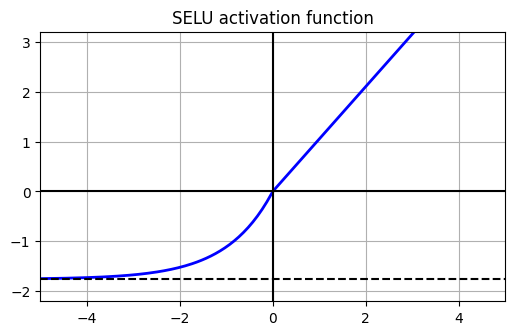

In [9]:
plt.figure(figsize=(6,3.5))
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=12)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

그러나 자기 정규화가 일어나기 위해서는 몇 가지 조건이 필요하다.
- **입력 특성**이 반드시 **평균 0, 표준편차 1로 표준화**되어야 한다.
- **모든 은닉층의 가중치**는 **르쿤 정규분포로 초기화**되어야 한다. 따라서 케라스에서 `kernel_initializer='lecun_normal'`로 설정한다.
- **네트워크는 일렬로 쌓은 층으로 구성**되어야 한다. 순환 신경망이나 스킵 연결과 같은 **순차적이지 않은 구조에 SELU 활성화 함수를 사용하면 자기 정규화되는 것을 보장하지 않아서** SELU가 다른 함수들보다 성능이 뛰어나지 않을 것이다.

SELU 활성화 함수를 사용하려면 `Dense`로 층을 만들 때 `activation`과 `kernel_initializer`를 다음과 같이 지정한다.

In [10]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

LeakyReLU 활성화 함수를 사용하려면 먼저 **`LeakyReLU()`**를 사용하여 LeakyReLU 층을 만들고, 모델에서 적용하려는 층 뒤에 추가한다. 이때 음수 범위에서의 기울기인 **$\alpha$ 값을 매개변수로 지정**할 수 있다.


In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

### 11.1.3 배치 정규화
**ELU와 함께 He 초기화를 사용**하면 **훈련 초기 단계에서 그래디언트 소실이나 폭주 문제를 크게 감소**시킬 수 있지만, **훈련하는 동안 다시 발생하지 않으리란 보장을 할 수 없다.**

2015년 한 논문에서 **그래디언트 소실과 폭주 문제를 해결**하기 위한 **배치 정규화(BN) 기법**이 소개되었다.

이 기법은 각 층에서 활성화 함수를 통과하기 전이나 후에 **모델에 연산을 하나 추가**한다. 이 연산은 단순하게 **입력 데이터를 원점에 맞추고 정규화**한 다음에, **각 층에서 2개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동**시킨다. 2개의 새로운 파라미터 중 **하나는 스케일 조정**에, **다른 하나는 이동**에 사용한다.

많은 경우에 `StandardScaler`를 사용하는 등 **신경망의 첫번째 층으로 배치 정규화를 추가**하면 배치 정규화 층이 이 역할을 대신하므로 훈련 세트를 표준화할 필요가 없다. 이는 한번에 하나의 배치만 처리하기 때문에 근사적이며, 입력 특성마다 스케일을 조정하고 이동할 수 있다.

모델에 추가되는 연산에서 입력 데이터를 **원점에 맞추고 정규화**하기 위해서는 **알고리즘이 평균과 표준편차를 추정**해야 한다. 이를 위해 **현재 미니배치에서 입력 데이터의 평균과 표준편차를 평가**한다.

> *배치 정규화 알고리즘*

1. $𝛍_B=\displaystyle\frac{1}{m_B}\sum_{i=1}^{m_B}𝐱^{(i)}$
2. $𝛔_B=\displaystyle\frac{1}{m_B}\sum_{i=1}^{m_B}(𝐱^{(i)}-𝛍_B)^2$
3. $\hat{𝐱^{(i)}}=\frac{𝐱^{(i)}-𝛍_B}{\sqrt{{𝛔_B}^2+𝜺}}$
4. $𝒛^{(i)}=𝜸\otimes\hat{𝐱^{(i)}}+𝛃$

훈련하는 동안 배치 정규화는 입력 데이터를 정규화한 다음 스케일을 조정하고 이동시킨다.

그러나 테스트 시에는 샘플의 배치가 아닌 샘플 하나에 대한 예측을 만들어야 하며, 이 경우 입력의 평균과 표준편차를 계산할 방법이 없다.

사용할 수 있는 한가지 방법은 **훈련이 끝난 후 전체 훈련 세트를 신경망에 통과시켜서 배치 정규화 층의 각 입력에 대한 평균과 표준편차를 계산**하는 것이다. 예측할 때 배치 입력 평균과 표준편차로 이 최종 입력 평균과 표준편차를 대신 사용할 수 있다.

그러나 대부분의 배치 정규화 구현은 **층의 입력 평균**과 **표준편차의 이동 평균**을 사용하여 **훈련하는 동안 최종 통계를 추정**하며, 케라스의 **`BatchNormalization`** 층은 이를 자동으로 수행한다.

정리하면 **배치 정규화 층마다 4개의 파라미터 벡터가 학습**된다.
- 출력 스케일 벡터 $𝛄$와 출력 이동 벡터 $𝛃$는 일반적인 **역전파를 통해 학습**된다.
- 최종 입력 평균 벡터 $𝛍$와 최종 입력 표준편차 벡터 $𝛔$는 **지수 이동 평균을 사용하여 추정**된다.
- $𝛍$와 $𝛔$는 훈련하는 동안 추정되지만, 훈련이 끝난 후에 사용된다.

이오페와 세게디는 실험한 모든 **심층 신경망에서 배치 정규화가 성능을 크게 향상시킨다**는 것을 보였다. 특히 여러 클래스로 분류된 대규모 이미지 데이터베이스인 이미지넷 분류 작업에서 큰 성과를 냈다.

**그래디언트 소실 문제가 크게 감소**하여 하이퍼볼릭 탄젠트 활성화 함수나 로지스틱 활성화 함수 같은 **수렴성을 가진 활성화 함수를 사용할 수 있다.**

또한 배치 정규화는 **규제**와 같은 역할을 하여 **다른 규제 기법의 필요성을 줄여준다.**

그러나 배치 정규화는 **모델의 복잡도를 키우게 되며**, 층마다 계산이 추가되므로 **실행 시간이 늘어나서 신경망의 예측을 느리게 한다**.

다행히 훈련이 끝난 후에 이전 층과 배치 정규화 층을 합쳐서 실행 속도가 저하되는 것을 피할 수 있다. 이전 층의 가중치를 바꾸어서 바로 스케일이 조정되고 이동된 출력을 만든다.

예를 들어 이전 층이 $𝐗𝐖+𝐛$를 계산하면 배치 정규화 층은 $𝛄\otimes(𝐗𝐖+𝐛-𝛍)/𝝈+𝜷$를 계산한다. 만약 $𝐖'=𝛄\otimes𝐖/𝝈, 𝐛'=𝛄\otimes(𝐛-𝛍)/𝝈+𝜷$를 정의하면 이 식은 $𝐗𝐖'+𝐛'$로 단순화된다.

따라서 이전 층의 가중치($𝐖$)와 편향($𝐛$)을 업데이트된 가중치($𝐖'$)와 편향$(𝐛')$으로 바꾸면 배치 정규화층을 제거할 수 있다.

#### 케라스로 배치 정규화 구현하기
배치 정규화 층도 케라스로 간단하고 쉽게 구현할 수 있다. **은닉층의 활성화 함수 전이나 후**에 **`BatchNormalization`** 층을 추가하면 된다. 또는 **모델의 첫번째 층**으로 배치 정규화 층을 추가할 수도 있다.

아래의 코드는 첫번째 층과 각 은닉층의 다음에 배치 정규화 층을 적용한 모델을 구현한 것이다.


In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

배치 정규화 층은 입력마다 4개의 파라미터 $𝛄, 𝛃, 𝛍, 𝛔$를 추가한다. 따라서 첫번째 배치 정규화 층에는 784x4=3136개, 두번째 배치 정규화 층에는 300x4=1200개, 세번째 배치 정규화 층에는 100x4=400개의 파라미터가 있다.

파라미터 중 $𝛍$과 $𝛔$는 이동 평균 파라미터로, **역전파로 학습되지 않기 때문**에 케라스는 이 둘을 **'Non-trainable' 파라미터로 분류**한다. 그렇기 때문에 총 배치 정규화 파라미터 3136+1200+400개를 2로 나눈 2368개만큼이 마지막에 훈련되지 않은 파라미터로 나타난다.

첫번째 배치 정규화 층의 파라미터를 살펴보면 2개는 역전파로 훈련되고(True), 2개는 훈련되지 않는다.(False)

케라스에서 배치 정규화 층을 만들 때 훈련하는 동안 매 반복마다 케라스에서 호출될 2개의 **연산이 함께 생성**되며, 이 연산이 **이동 평균을 업데이트**한다.

In [14]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

배치 정규화 논문의 저자들은 **활성화 함수 이전 층에 배치 정규화 층을 추가하는 것이 좋다**고 하였다. 그러나 작업에 따라 선호되는 방식이 다르므로 두 방법 모두 실험해보고 데이터셋에 가장 잘 맞는 방법을 사용하는 것이 좋다.

활성화 함수 전에 배치 정규화 층을 추가하려면 **은닉층에서 활성화 함수를 지정하지 않고**, 배치 정규화 층 뒤에 **별도의 `Activation` 층으로 추가**해야 한다.

또한 배치 정규화 층은 입력마다 이동 파라미터를 포함하므로 이전의 층은 편향을 위한 항이 필요가 없다. 따라서 필요 없는 파라미터이므로 `use_biase=False`로 설정하여 이전 층에서 편향을 뺄 수 있다.


In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

`BatchNormalization` 클래스는 조정할 하이퍼파라미터가 적으며, 보통 기본값으로 잘 작동한다.

`BatchNormalization` 층이 **지수 이동 평균을 업데이트**할 때 **`momentum`** 매개변수를 사용하며, 가끔 `momentum`를 변경해야 할 때가 있다. 현재 배치에서 계산한 **새로운 입력 평균 벡터나 표준편차 벡터**가 주어지면 다음의 식을 사용해서 **이동 평균 $\hat{𝐯}$를 계산**한다. 적절한 값은 0.9, 0.99와 같이 일반적으로 1에 가깝다.

$\hat{𝐯}⟵\hat{𝐯}·momentum+𝐯·(1-momentum)$

중요한 다른 하이퍼파라미터는 `axis`로, 이 매개변수는 **정규화할 축을 결정**한다. 기본값은 -1로, 다른 축을 따라 계산한 평균과 표준편차를 사용하여 마지막 축을 정규화한다.

배치 정규화 층은 훈련 도중과 훈련이 끝난 후에 수행하는 계산이 다르다. **훈련하는 동안에는 배치 통계**를 사용하고, **훈련이 끝난 후에는 이동 평균의 마지막 값인 최종 통계**를 사용한다.

`BatchNormalization`은 심층 신경망에서 매우 널리 사용하는 층으로, **보통 모든 층의 뒤에 배치 정규화 층이 있다고 가정**하여 종종 신경망 그림에서 빠져있기도 한다.

### 11.1.4 그래디언트 클리핑
**그래디언트 폭주 문제를 완화**할 수 있는 다른 방법은 **역전파될 때 일정 임계값을 넘어서지 못하게 그래디언트를 잘라내는 것**으로, 이를 **그래디언트 클래핑**이라고 한다. 다른 종류의 네트워크는 보통 배치 정규화면 충분하지만, **순환 신경망**은 배치 정규화를 적용하기 어려워서 이 방법을 많이 사용한다.

케라스에서 그래디언트 클리핑을 구현하려면 다음과 같이 옵티마이저를 만들 때 **`clipvalue`와 `clipnorm`** 매개변수를 지정하면 된다.

이 옵티마이저는 **그래디언트 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑**한다. 즉 훈련되는 각 파라미터에 대한 손실의 모든 편미분 값을 -1.0에서 1.0으로 잘라낸다. 임계값은 하이퍼파라미터로 튜닝할 수 있으며, 이 기능은 **그래디언트 벡터의 방향을 바꿀 수 있다.**

예를 들어 그래디언트 벡터가 [0.9,100.0]이라면 대부분 두번째 축 방향을 향한다. 그러나 값을 기준으로 이를 클리핑 하면 [0.9,1.0]이 되고, 거의 두 축 사이 대각선 방향을 향하게 된다.


In [16]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

만약 그래디언트 클리핑이 그래디언트 벡터 방향을 바꾸지 못하게 하려면 `clipvalue` 대신 `clipnorm`을 지정하여 노름으로 클리핑해야 한다. 만약 $l_2$ 노름이 지정한 임계값보다 크면 전체 그래디언트를 클리핑한다.

예를 들어 `clipnorm=1.0`으로 지정한다면 벡터 [0.9,100.0]이 [0.00899964,0.9999595]로 클리핑되므로 방향을 그대로 유지하지만, 첫번째 원소는 거의 무시된다.

훈련하는 동안 그래디언트가 폭주한다면 다른 임계값으로 값과 노름을 모두 사용하여 클리핑할 수 있다. 그리고 검증 세트를 이용하여 어떤 방식이 가장 좋은 성과를 내는지 확인할 수 있다.

In [17]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 11.2 사전훈련된 층 재사용하기
일반적으로 아주 큰 규모의 심층 신경망을 처음부터 새로 훈련하는 것은 좋지 않다. 해결하려는 것과 **비슷한 유형의 문제를 처리한 신경망이 이미 있는지** 먼저 찾아본 다음, 그 **신경망의 하위층을 재사용**하는 것이 좋다. 이를 **전이 학습**이라고 하며, 이 방법은 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.

예를 들어 동물, 식물, 자동차, 생활용품을 포함한 100개의 카테고리로 구분된 이미지를 분류하도록 훈련된 심층 신경망을 가지고 있다고 가정하고, 이제 구체적인 자동차의 종류를 분류하는 심층 신경망을 훈련하려고 한다. 이런 작업들은 비슷한 점이 많고, 심지어 일부가 겹치므로 첫번째 신경망의 일부를 재사용해봐야 한다.

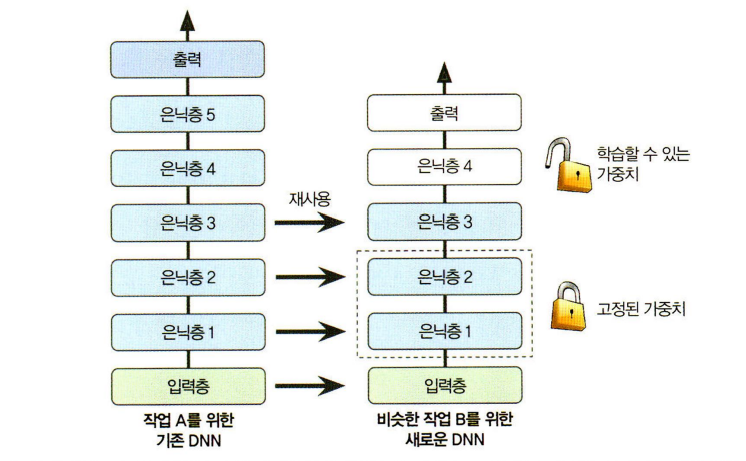

위의 그림은 사전훈련된 심층 신경망을 재사용하는 방법을 이미지로 나타낸 것이다.

보통은 **원본 모델에서의 출력층을 바꿔야 한다.** 출력층이 새로운 작업에 가장 유용하지 않는 층이고, 새로운 작업에 필요한 출력 개수와 맞지 않을 가능성이 높기 때문이다.

비슷하게 **원본 모델의 상위 은닉층은 하위 은닉층보다 덜 유용하다.** 새로운 작업에 유용한 고수준 특성은 원본 작업에서 유용했던 특성과는 상당히 다르기 때문이다.

먼저 **재사용하는 층을 모두 동결**한다. 즉 경사 하강법으로 가중치가 바뀌지 않도록 **훈련되지 않는 가중치로 만드는 것**이다.

그 다음 **모델을 훈련하고 성능을 평가**한다. **맨 위에 있는 1~2개의 은닉층의 동결을 해제**하고, **역전파를 통해 가중치를 조정하여 성능이 향상되는지를 확인**한다. 훈련 데이터가 많을수록 많은 층의 동결을 해제할 수 있다. 재사용 층의 동결을 해제할 때 학습률을 줄이면 가중치를 세밀하게 튜닝하는데 도움이 된다.

만약 여전히 좋은 성능을 낼 수 없고 훈련 데이터가 적다면 **상위 은닉층을 제거**하고 **남은 은닉층을 다시 동결**한다. 이런 식으로 재사용할 은닉층의 적절한 개수를 찾을 때까지 반복하여 재사용할 층 개수를 잘 선정해야 한다. 훈련 데이터가 아주 많다면 은닉층을 제거하는 대신 다른 것으로 바꾸거나, 심지어 더 많은 은닉층을 추가할 수도 있다.

### 11.2.1 케라스를 사용한 전이 학습
예를 들어 8개의 클래스만 있는 패션 MNIST 데이터셋에 대하여 클래스를 분류하는 작업을 A라고 하고 이 작업 A를 해결하는 모델 A를 만들어서 90% 이상의 정확도를 얻었다고 가정한다.

이제 샌들과 셔츠 이미지를 구분하는 작업 B를 해결하기 위해 **셔츠를 양성으로, 샌들을 음성으로** 구분하는 이진 분류기를 만드려고 한다. 레이블된 이미지는 겨우 200개로 준비된 데이터가 매우 적으며 이를 위해 모델 A와 구조가 거의 비슷한 모델 B를 만들고 훈련시켜서 97.2%의 정확도를 얻었다.

그러나 작업 B는 꽤 간단한 작업이므로 더 좋은 성능을 얻고자 한다. 이를 위해 **작업 B가 모델 A가 해결하는 작업 A와 매우 비슷하다**는 점을 이용하여 **전이 학습** 방법을 사용하기로 하였다. 따라서 모델 A를 기반으로 새로운 모델 model_B_on_A를 만든다.

먼저 패션 MNIST 훈련 세트를 2개로 나눈다.
- X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
- X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 마찬가지로 나눈다.






In [18]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 1s 0us/step


In [19]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [20]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

먼저 모델 A를 만들고 훈련시킨 다음, "my_model_A.h5"로 저장한다.

In [21]:
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [22]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.6320 - accuracy: 0.7956 - val_loss: 0.4221 - val_accuracy: 0.8533
Epoch 2/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.3671 - accuracy: 0.8744 - val_loss: 0.3423 - val_accuracy: 0.8809
Epoch 3/20
1375/1375 [==============================] - 10s 8ms/step - loss: 0.3222 - accuracy: 0.8884 - val_loss: 0.3079 - val_accuracy: 0.8949
Epoch 4/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.2999 - accuracy: 0.8962 - val_loss: 0.2942 - val_accuracy: 0.8969
Epoch 5/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2857 - accuracy: 0.9009 - val_loss: 0.2809 - val_accuracy: 0.9003
Epoch 6/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2753 - accuracy: 0.9050 - val_loss: 0.2751 - val_accuracy: 0.9001
Epoch 7/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2667 - accuracy: 0.9079 - val_loss: 0.2719 - val_accurac

In [23]:
model_A.save("my_model_A.h5")

저장한 모델 A를 로드하고 이 모델의 층을 기반으로 하여 새로운 모델 model_B_on_A를 만든다. 이를 위해서 모델 A의 **마지막 출력층만 제외하고 모든 층을 재사용**한다.

`model_A = keras.models.load_model("my_model_A.h5")`

`model_B_on_A = keras.models.Sequential(model_A.layers[:-1])`

`model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))`

위의 코드처럼 model_B_on_A와 model_A는 층을 공유하기 때문에 model_B_on_A를 훈련하면 model_A도 영향을 받아 **두 모델이 같이 업데이트**된다. 이를 피하기 위해서는 **층을 재사용하기 전**에 먼저 model_A를 **클론**해야 한다.

**`clone_model()`** 메서드를 사용하면 **모델 A의 구조를 복제**하며, 이때 가중치는 복제하지 않는다. 다음으로 **`get_weights()`** 메서드로 **모델의 가중치를 복사**하고, 클론 모델에 **`set_weights()`** 메서드로 **가중치를 설정**하여 model_B_on_A를 만들 수 있다.

In [24]:
model_A = keras.models.load_model("my_model_A.h5")
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [25]:
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

이제 작업 B를 위해 만든 model_B_on_A를 훈련할 수 있다. 하지만 **새로운 출력층이 랜덤하게 초기화**되어 있으므로 적어도 **처음 몇 번의 에포크 동안에는 큰 오차**를 만들 것이다. 이때문에 **큰 오차 그래디언트가 재사용된 가중치를 망칠 수 있다.**

큰 오차가 생기는 것을 피하는 한가지 방법은 **처음 몇 번의 에포크 동안 재사용된 층을 동결**하고, **새로운 층에게 적절한 가중치를 학습할 시간을 주는 것**이다. 이를 위해서는 **모든 층의 `trainable` 속성을 `False`로 지정하고 모델을 컴파일**한다.

이제 몇 번의 에포크동안 모델을 훈련시킨다.

In [26]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 49ms/step - loss: 1.8611 - accuracy: 0.1250 - val_loss: 1.7470 - val_accuracy: 0.1481
Epoch 2/4
7/7 [==============================] - 0s 17ms/step - loss: 1.7302 - accuracy: 0.1600 - val_loss: 1.6267 - val_accuracy: 0.1724
Epoch 3/4
7/7 [==============================] - 0s 30ms/step - loss: 1.6071 - accuracy: 0.1850 - val_loss: 1.5122 - val_accuracy: 0.2079
Epoch 4/4
7/7 [==============================] - 0s 19ms/step - loss: 1.4904 - accuracy: 0.1850 - val_loss: 1.4063 - val_accuracy: 0.2312


이렇게 재사용된 층을 동결시키고 새로운 층이 적절한 가중치를 학습할 수 있도록 훈련한 다음에는, **다시 재사용된 층의 동결을 해제하고 모델을 컴파일**한다.

이를 위해서는 반대로 **모든 층의 `trainable` 속성을 `True`로 지정**한다.

일반적으로 재사용된 층의 동결을 해제한 후에 학습률을 낮추어야 재사용된 가중치가 망가지는 것을 막을 수 있다.

In [27]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 81ms/step - loss: 1.2036 - accuracy: 0.3150 - val_loss: 0.9179 - val_accuracy: 0.4757
Epoch 2/16
7/7 [==============================] - 0s 29ms/step - loss: 0.7821 - accuracy: 0.5600 - val_loss: 0.6424 - val_accuracy: 0.6410
Epoch 3/16
7/7 [==============================] - 0s 26ms/step - loss: 0.5470 - accuracy: 0.7000 - val_loss: 0.4866 - val_accuracy: 0.7535
Epoch 4/16
7/7 [==============================] - 0s 35ms/step - loss: 0.4104 - accuracy: 0.8300 - val_loss: 0.3881 - val_accuracy: 0.8418
Epoch 5/16
7/7 [==============================] - 0s 29ms/step - loss: 0.3238 - accuracy: 0.8800 - val_loss: 0.3195 - val_accuracy: 0.8976
Epoch 6/16
7/7 [==============================] - 0s 27ms/step - loss: 0.2620 - accuracy: 0.9400 - val_loss: 0.2721 - val_accuracy: 0.9239
Epoch 7/16
7/7 [==============================] - 0s 36ms/step - loss: 0.2198 - accuracy: 0.9700 - val_loss: 0.2379 - val_accuracy: 0.9452
Epoch 8/16
7/7 [===========

In [28]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1102 - accuracy: 0.9800


[0.11023338884115219, 0.9800000190734863]

모델의 테스트 정확도가 98%로 향상되었다.

전이 학습은 **작은 완전 연결 네트워크에서는 잘 동작하지 않는데,** 아마도 작은 네트워크는 패턴 수를 적게 학습하고 완전 연결 네트워크는 특정 패턴을 학습하기 때문이다.

**전이 학습**은 조금 더 **일반적인 특성을 감지**하는 경향이 있는 **심층 합성곱 신경망에서 잘 동작**한다.

### 11.2.2 비지도 사전훈련
**비지도 사전훈련**은 **레이블된 훈련 데이터가 많지 않은 경우**에 사용한다. 비지도 학습 기법을 사용하여 레이블이 없는 데이터로 모델을 훈련하는 것이다.
특히 **풀어야하는 문제가 복잡하고, 재사용할 수 있는 비슷한 모델이 없고, 레이블된 훈련 데이터는 적은데 그렇지 않은 데이터가 많을 때**는 **오토인코더나 GAN을 사용한 비지도 사전훈련**을 수행하는 것이 좋은 방법이다.

레이블되지 않은 훈련 데이터를 많이 모을 수 있다면 이를 이용하여 오토인코더나 생성적 적대 신경망과 같은 비지도 학습 모델을 훈련할 수 있다. 그 다음으로 오토인코더나 GAN 판별자의 하위층을 재사용하고 그 위에 새로운 작업에 맞는 출력층을 추가한다. 그 다음에 레이블된 훈련 샘플, 즉 지도 학습으로 최종 네트워크를 세밀하게 튜닝한다.

아래의 그림은 비지도 사전훈련 과정을 나타낸 것이다.

먼저 **하나의 층을 가진 비지도 학습 모델을 훈련**한다. 이때 일반적으로 **RBM**을 사용한다. 그 다음 **이 층을 동결**하고, 그 **위에 다른 층을 추가한 모델을 다시 훈련하여 새로 추가한 층만 훈련**시킨다. 이제 이 새로운 층으르 동결하고 그 위에 또 다른 층을 추가하고 모델을 다시 훈련하는 식으로 **반복**한다.

요즘에는 훨씬 더 간단한 방법을 사용할 수 있다. 일반적으로 **한 번에 전체 비지도 학습 모델을 훈련**하는 것으로, 이때는 **RBM 대신 오토인코너나 GAN을 사용**한다. 아래 그림에서 바로 3번째 단계를 시작하는 것이다.

마지막으로 지도 학습을 사용하여 출력층을 훈련한다.



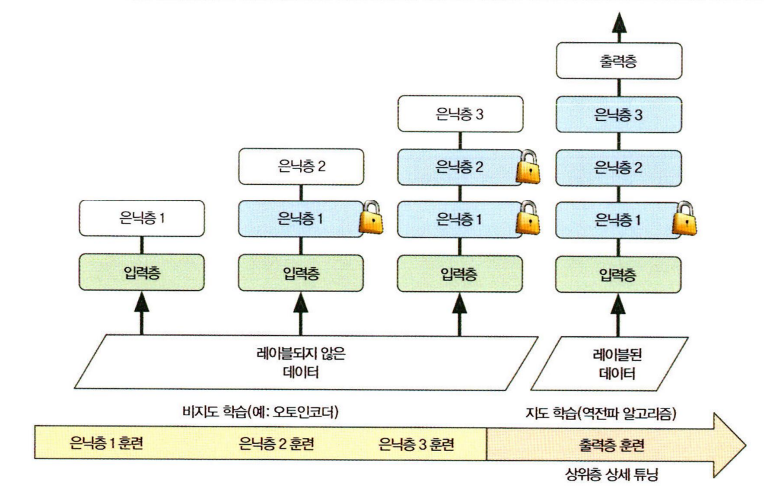

### 11.2.3 보조 작업에서 사전훈련
만약 레이블된 훈련 데이터가 많지 않다면 **레이블된 훈련 데이터를 쉽게 얻거나 생성할 수 있는 보조 작업에서 첫번째 신경망을 훈련**할 수 있다. 그리고 **이 신경망의 하위 층을 실제 작업을 위해 재사용**한다. 첫번째 신경망의 하위층은 **두번째 신경망에 재사용될 수 있는 특성 추출기를 학습**하게 된다.

예를 들어 얼굴을 인식하는 시스템을 만드려는데 개인별 이미지가 얼마 없다면 좋은 분류기를 훈련할 수 없다. 각 사람의 사진을 수백 개씩 모으는 것은 현실적으로 어려우므로, 인터넷에서 무작위로 많은 인물의 이미지를 수집하여 2개의 다른 이미지가 같은 사람인지 감지하는 첫번째 신경망을 훈련한다.

이 첫번째 신경망은 얼굴의 특성을 잘 감지하도록 학습될 것이므로, 이런 신경망의 하위층을 재사용하여 적은 양의 훈련 데이터에서 얼굴을 잘 구분하는 분류기를 훈련할 수 있다.

자연어 처리(NLP) 작업에서 이 방법을 사용할 수 있다. 수백만 개의 텍스트 문서로 이루어진 코퍼스를 다운로드하고, 이 데이터를 이용하여 레이블된 데이터를 자동으로 생성할 수 있다. 예를 들어 일부 단어를 랜덤하게 지워서 누락된 단어가 are인지 were인지 예측하는 모델을 만드는 것이다.

이 작업에서 좋은 성능을 내는 모델을 훈련시킬 수 있다면 언어에 대해 상당히 많은 것을 알고 있는 모델을 만드는 것이다. 따라서 실제 작업에 이 모델을 재사용하고 레이블된 데이터를 사용하여 모델을 세부 튜닝할 수 있다.

## 11.3 고속 옵티마이저
아주 큰 심층 신경망의 훈련 속도는 아주 느릴 수 있다. 지금까지 이를 개선할 수 있는 훈련 속도를 높이는 4가지 방법을 알아보았다.
- **연결 가중치에 좋은 초기화 전략 적용하기**
- **좋은 활성화 함수 사용하기**
- **배치 정규화 사용하기**
- **비지도 학습 또는 보조 작업을 사용하여 만들 수 있는 사전훈련된 네트워크의 일부 재사용하기**

또 다른 방법으로 표준적인 경사 하강법 옵티마이저 대신에 더 빠른 옵티마이저를 사용할 수 있다. 가장 인기 있는 옵티마이저 **모멘텀 최적화** 외에도 **네스테로프 가속 경사, AdaGrad, RMSProp, Adam, Nadam** 옵티마이저가 있다.

### 11.3.1 모멘텀 최적화
모멘텀 최적화의 간단한 원리는 볼링공이 매끈한 표면의 완만한 경사를 따라 굴러갈 때, **처음에는 느리게 출발하지만 종단속도에 도달할 때까지는 빠르게 가속될 것**이라는 것에서 시작한다. 반대로 **표준적인 경사 하강법**은 경사면을 따라 **일정한 크기의 스텝으로 조금씩 내려가므로**, 가장 아래까지 도착하는데 더 오랜 시간이 걸린다.

경사 하강법은 **가중치에 대한 비용 함수의 그래디언트에 학습률을 곱한 것을 차감하여 가중치를 갱신**한다. $𝜽 ← 𝜽-\eta∇_{\theta}J(𝜽)$ 해당 공식은 **이전의 그래디언트가 얼마였는지 고려하지 않는다.** 국부적으로 그래디언트가 아주 작으면 매우 느려질 것이다.

**모멘텀 최적화는 이전 그래디언트가 얼마였는지를 중요하게 생각**한다. 매 반복에서 현재 그래디언트에 학습률 $\eta$를 곱하고, 모멘텀 벡터 $𝐦$에서 이 값을 빼는 방식으로 가중치를 갱신한다. 모멘텀 알고리즘의 공식은 다음과 같다.

> *모멘텀 알고리즘*
1. $𝐦 ← \beta𝐦-\eta∇_{\theta}J(𝜽)$
2. $𝜽 ← 𝜽+𝐦$

이때 일종의 마찰 저항을 표현하고 모멘텀 값이 너무 커지는 것을 막기 위해 **모멘텀이라는 새로운 하이퍼파라미터 $\beta$**가 등장한다. 이 값은 **높은 마찰 저항을 나타내는 0과 마찰 저항이 없는 1 사이의 값**으로 설정되어야 하며, 일반적으로 **0.9**이다.


그래디언트가 일정하다면 종단속도는 학습률 $\eta$를 곱한 그래디언트에 $\frac{1}{1-\beta}$를 곱한 것과 같다. 이는 **모멘텀 최적화가 경사 하강법보다 더 빠르게 평평한 지역을 탈출**하도록 도와준다.

특히 **입력값의 스케일이 매우 달라서** 비용 함수가 한쪽이 길쭉한 모양인 경우, 경사 하강법은 가파른 경사는 빠르게 내려가지만 좁고 긴 골짜기에서는 수렴하기까지 오랜 시간이 걸린다. 반면 **모멘텀 최적화는 골짜기를 따라 바닥의 최적점에 도달할 때까지 점점 더 빠르게 내려간다.** 배지 정규화를 사용하지 않는 심층 신경망의 상위층은 종종 스케일이 매우 다른 입력을 받게 되며, 이때 모멘텀 최적화를 사용하면 큰 도움이 된다.

또한 모멘텀 최적화는 모멘텀 때문에 옵티마이저가 최적값에 안정되기 전까지 건너뛰었다가 다시 돌아오고, 다시 또 건너뛰는 식으로 여러번 왔다갔다 한다. 이러한 이유로 **모멘텀 최적화는 지역 최적점을 건너뛰도록 하는데에도 도움**이 된다.

케라스에서 모멘텀 최적화를 구현하는 방법은 `SGD` 옵티마이저를 사용하고, `momentum` 매개변수에 모멘텀 하이퍼파라미터 값을 지정하면 된다.

모멘텀 최적화의 한가지 단점은 튜닝할 하이퍼파라미터가 하나 늘어난 것이다. 그러나 실제로 모멘텀 값이 0.9이면 보통 잘 작동하고, 경사 하강법보다 거의 항상 더 빠르다.

In [29]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### 11.3.2 네스테로프 가속 경사
**네스테로프 가속 경사(NAG) 또는 네스테로프 모멘텀 최적화**는 모멘텀 최적화의 한 변종으로, **기본 모멘텀 최적화보다 거의 항상 더 빠르다.** 이 방법의 알고리즘은 현재 위치를 $𝜽$로 계산하는 것이 아니라 **모멘텀 방향으로 조금 앞선 $𝜽+\beta𝐦$에서 비용 함수의 그래디언트를 계산**하는 것이다.

> *네스테로프 가속 경사 알고리즘*
1. $𝐦 ← \beta𝐦-\eta∇_{\theta}J(𝜽+\beta𝐦)$
2. $𝜽 ← 𝜽+𝐦$

일반적으로 모멘텀 벡터는 최적점을 향하는 올바른 방향을 가리킬 것이므로 이러한 변경이 가능하다.

아래의 그림은 비용 함수에서 기본 모멘텀 최적화 방법과 네스테로프 최적화 방법의 업데이트를 나타낸 것이다.

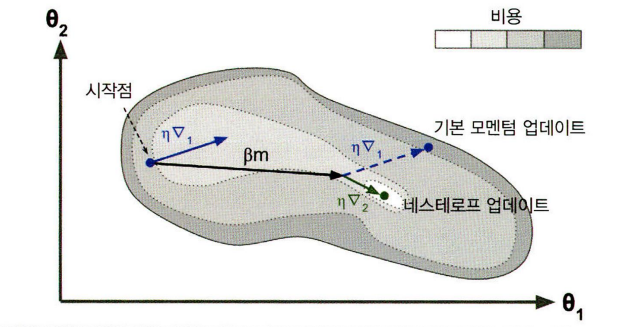

$∇_1$은 시작점 $𝜽$에서 측정한 비용 함수의 그래디언트, $∇_2$는 $𝜽+\beta𝐦$에서 측정한 비용 함수의 그래디언트를 나타낸다. 위의 그림에서처럼 원래 위치에서의 그래디언트를 사용하는 것보다 그 방향으로 **조금 더 나아가서 측정한 그래디언트를 사용하는 것이 약간 더 정확**하다.

그림에서 볼 수 있듯이 **네스테로프 업데이트가 최적값에 조금 더 가깝다.** 시간이 지나면 작은 개선들이 쌓여서 네스테로프 가속 경사 방법이 기본 모멘텀 최적화보다 확연히 빨라지게 된다.

게다가 모멘텀이 골짜기를 가로지르도록 가중치에 힘을 가할 때 $∇_1$은 골짜기를 더 가로지르도록 독려하는 반면, $∇_2$는 계곡의 아래쪽으로 잡아당기게 된다. 이는 진동을 감소시키고 최적점으로의 수렴을 더 빠르게 한다.

**네스테로프 가속 경사**는 일반적으로 기본 모멘텀 최적화보다 **훈련 속도가 빠르다.** 케라스에서 이를 사용하기 위해서는 **`SGD` 옵티마이저를 만들 때 매개변수 `nestreov`를 `True`로 설정**한다.

In [30]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad
비용 함수가 한쪽으로 길쭉할 때 경사 하강법은 전역 최적점 방향으로 곧장 향하지 않고, 가장 가파른 경사를 따라 빠르게 내려가기 시작하여 골짜기 아래로 느리게 이동한다.

**AdaGrad 알고리즘**은 이러한 문제점을 해결하기 위해 **가장 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소시키는 방식**을 사용한다. 알고리즘에서 사용하는 공식은 다음과 같다.

> *AdaGrad 알고리즘*
1. $𝘀 ← 𝘀+∇_{\theta}J(𝜽)\otimes∇_{\theta}J(𝜽)$
2. $𝜽 ← 𝜽-\eta∇_{\theta}J(𝜽)\oslash\sqrt{𝘀+𝛆}$

첫번째 단계는 그래디언트의 제곱을 벡터 $𝘀$에 누적한다. 이 벡터화된 식은 벡터 $𝘀$의 각 원소 $s_i$마다 $s_i ← s_i+(\partial J(𝜽)/\partial\theta_i)^2$를 계산하는 것과 동일하다. 즉 $s_i$는 파라미터 $\theta_i$에 대한 비용 함수의 편미분을 제곱하여 누적한다. 비용 함수가 $i$번째 차원을 따라 가파르다면 $s_i$는 반복이 진행됨에 따라 점점 커질 것이다.

두번째 단계는 경사 하강법과 거의 같으며, 그래디언트 벡터를 $\sqrt{𝘀+𝛆}$로 나누어 스케일을 조정한다는 점에서 다르다. 이 벡터화된 식은 모든 파라미터 $\theta_i$에 대하여 동시에 $\theta_i ← \theta_i-\eta∇_{\theta}J(𝜽)/\partial\theta_i/\sqrt{s_i+𝛆}$를 계산하는 것과 동일하다.

요약하자면 **AdaGrad 알고리즘은 학습률을 감소**시키며, 경사가 완만한 차원보다 **경사가 가파른 차원에 대해서 더 빠르게 감소**된다. 이를 **적응적 학습률**이라고 부르며, **전역 최적점 방향으로 더 곧장 가도록 갱신하는데 도움**이 된다. 또한 학습률 하이퍼파라미터인 $\eta$를 덜 튜닝해도 된다는 장점이 있다.

아래 그림은 AdaGrad와 경사 하강법이 전역 최적점으로 수렴하는 과정을 나타낸 것이다. AdaGrad 알고리즘은 최적점을 향하여 일찍 방향을 바꿀 수 있으므로 주황색 점들이 더 가파르고 빠르게 감소한다.

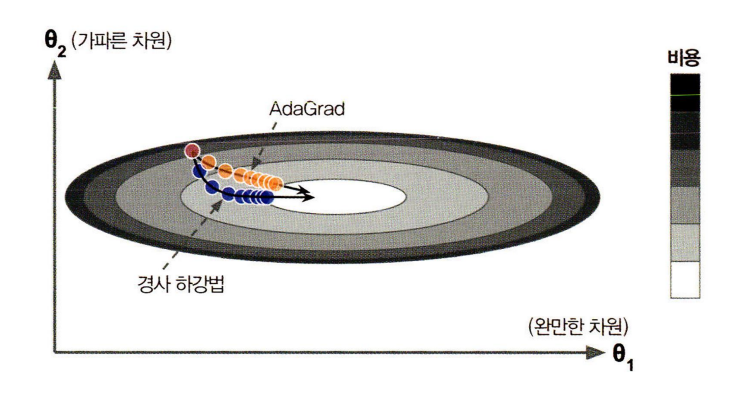

AdaGrad 알고리즘은 간단한 2차방정식 문제에서는 잘 작동하지만 신경망을 훈련할 때 종종 너무 멈추는 경우가 있다. 학습률이 너무 감소되어서 **전역 최적점에 도착하기 전에 알고리즘이 완전히 멈추게 된다.**

케라스의 **`Adagrad`** 옵티마이저를 이용하여 AdaGrad 알고리즘을 구현할 수 있지만,심층 신경망에서는 사용하지 않아야 한다. 하지만 선형 회귀 같은 간단한 작업에서는 효과적이다.

In [31]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

### 11.3.4 RMSProp
AdaGrad 알고리즘은 **너무 빨리 느려져서 멈추게 되어 전역 최적점에 수렴하지 못하는** 위험이 있다.

**RMSProp 알고리즘**은 훈련 시작부터의 모든 그래디언트가 아닌 **가장 최근 반복에서 비롯된 그래디언트만 누적함**으로써 이 문제를 해결했다. 이를 위해서 알고리즘의 **첫번째 단계에서 지수 감소를 사용**한다. RMSProp 알고리즘에서 사용하는 공식은 다음과 같다.

> *RMSProp 알고리즘*
1. $𝘀 ← \beta𝘀+(1-\beta)∇_{\theta}J(𝜽)\otimes∇_{\theta}J(𝜽)$
2. $𝜽 ← 𝜽-\eta∇_{\theta}J(𝜽)\oslash\sqrt{𝘀+𝛆}$

감쇠율을 의미하는 $\beta$는 보통 0.9로 설정한다. 하이퍼파라미터가 하나 새로 생겼지만 기본값이 잘 작동하는 경우가 많으므로 튜닝할 필요가 없다.

RMSProp 알고리즘은 케라스에 있는 **`RMSProp`** 옵티마이저를 사용하여 구현할 수 있다. 매개변수 `rho`은 감쇠율이자 위의 공식에서의 $\beta$이다.

아주 간단한 문제를 제외하고는 RMSProp 알고리즘이 AdaGrad 알고리즘보다 훨씬 더 성능이 좋다.

In [32]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### 11.3.5 Adam과 Nadam 최적화
**적응적 모멘트 추정**을 의미하는 **Adam**은 **모멘텀 최적화와 RMSProp의 아이디어를 합친 것**이다.

모멘텀 최적화처럼 지난 그래디언트의 지수 감소 평균을 따르고, RMSProp처럼 지난 그래디언트 제곱의 지수 감소된 평균을 따른다.

> *Adam알고리즘*
1. $𝐦 ← \beta_1𝐦-(1-\beta_1)∇_{\theta}J(𝜽)$
2. $𝘀 ← \beta_2𝘀+(1-\beta_2)∇_{\theta}J(𝜽)\otimes∇_{\theta}J(𝜽)$
3. $\hat{𝐦} ← \frac{𝐦}{1-\beta_1^t}$
4. $\hat{𝘀} ← \frac{𝘀}{1-\beta_2^t}$
5. $𝜽 ← 𝜽+\eta\hat{𝐦}\oslash\sqrt{\hat{𝘀}+𝛆}$  
t는 1부터 시작하는 반복 횟수

단계 1,2,5를 보면 Adam 알고리즘이 모멘텀 최적화, RMSProp 알고리즘과 아주 비슷한 것을 알 수 있다. 단계 3과 4는 훈련 초기에 $𝐦, 𝘀$의 값을 증폭시키는 역할을 한다. 이는 $𝐦, 𝘀$이 0으로 초기화되면서 훈련 초기에 0쪽으로 치우치게 되기 때문이다.

모멘텀 감쇠 하이퍼파라미터 $\beta_1$은 보통 0.9로, 스케일 감쇠 하이퍼파라미터 $\beta_2$는 0.999로 초기화하는 경우가 많다. 또한 앞에서처럼 안정된 계산을 위해 $𝛆$은 $10^{-7}$과 같은 아주 작은 수로 초기화한다. 이것이 `Adam` 클래스의 기본값이다.

다음은 케라스에서 **`Adam`** 옵티마이저를 만드는 코드이다. Adam 알고리즘이 적응적 학습률 알고리즘이기 때문에 학습률 하이퍼파라미터 $\eta$를 튜닝할 필요가 적다. 기본값 `learning_rate=0.001`을 일반적으로 사용하므로 경사 하강법보다 Adam 알고리즘이 더 사용하기 쉽다.

In [33]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### AdaMax
Adam 알고리즘의 공식의 2단계에서 $𝘀$에 그래디언트 제곱을 누적하여 최근 그래디언트에 더 큰 가중치를 부여한다. 5단계의 $𝛆$와 3,4단계를 무시하면 Adam은 $𝘀$의 제곱근으로 파라미터 업데이트의 스케일을 낮춘다. 즉 Adam 알고리즘은 시간에 따라 감쇠된 그래디언트의 $l_2$ 노름으로 파라미터 업데이트의 스케일을 낮춘다.

Adam과 같은 논문에서 소개된 AdaMax 알고리즘은 $l_2$ 노름 대신에 $l_{\infty}$ 노름을 사용한다. 사용하는 공식은 다음과 같다.

> *AdaMax알고리즘*
1. $𝐦 ← \beta_1𝐦-(1-\beta_1)∇_{\theta}J(𝜽)$
2. $𝘀 ← \max(\beta_2𝘀,∇_{\theta}J(𝜽))$
3. $\hat{𝐦} ← \frac{𝐦}{1-\beta_1^t}$
4. $𝘀$에 비례하여 그래디언트 업데이트의 스케일을 낮춘다.

실전에서는 **AdaMax 알고리즘이 Adam보다 더 안정적**이지만, 실제로 데이터셋에 따라 다르고 일반적으로 **Adam의 성능이 더 낫다.** 만약 어떤 작업에서 Adam이 잘 작동하지 않는다면 AdaMax 옵티마이저를 시도해볼 수 있다.

케라스에서 **`Adamax`** 옵티마이저를 이용하여 구현할 수 있다.


In [34]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### Nadam
**Ndam 옵티마이저**는 **Adam 옵티마이저에 네스테로프 기법을 더한 것**이다. 따라서 종종 Adam보다 조금 **더 빠르게 수렴**한다.

케라스에서 **`Nadam`** 옵티마이저를 이용하여 구현할 수 있다.


In [35]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

아래의 표는 지금까지 소개한 모든 옵티마이저를 비교한 것이다.

각 클래스의 이름과 수렴 속도, 수렴 품질을 나타내었으며, 성능을 별 1개는 나쁨, 별 2개는 보통, 별 3개는 좋음을 의미한다.

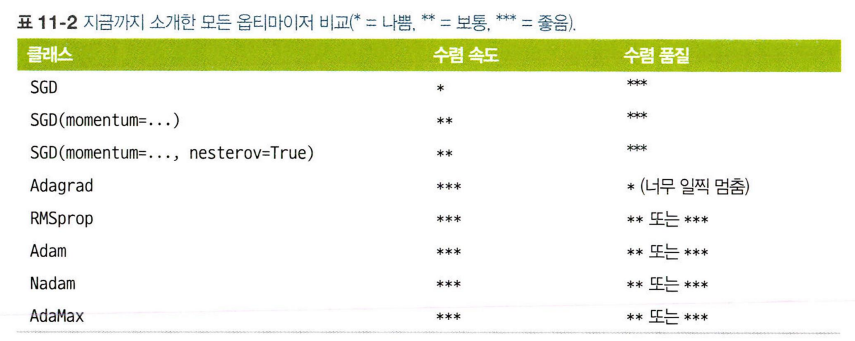

### 11.3.6 학습률 스케줄링
아래의 그림은 여러 가지 학습률 $\eta$에 대한 학습 곡선을 나타낸 것이다.


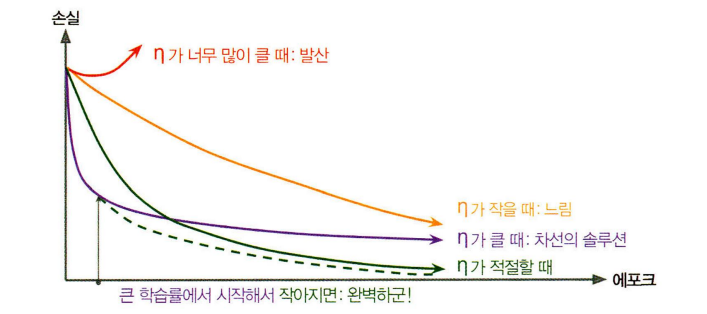

학습률이 너무 큰 경우 훈련이 발산하게 되거나, 학습률이 너무 작은 경우 최적점에 수렴하기까지 매우 오랜 시간이 걸릴 수 있다. 또는 학습률이 조금 높은 경우는 처음에는 매우 빠르게 진행하겠지만 최적점 근처에서는 요동이 심해져서 수렴하지 못할 것이다.

따라서 좋은 학습률을 찾는 것이 매우 중요하다. 이를 위해서 **매우 작은 값에서 매우 큰 값까지 지수적으로 학습률을 증가시키면서 모델 훈련을 수백 번 반복**하면 좋은 학습률을 찾을 수 있다. 그 다음 학습 곡선을 살펴보며 다시 상승하는 곡선보다 조금 더 작은 학습률을 선택하고, 모델을 초기화하고 이 학습률로 훈련한다.

그러나 일정한 학습률을 선택하는 것보다 더 나은 방법이 있다. **큰 학습률로 시작하여 학습 속도가 느려질 때 학습률을 낮추면** 최적의 고정 학습률을 사용하는 것보다 **더 빠르게 좋은 솔루션을 발견**할 수 있다. 이러한 전략을 **학습 스케줄**(learning schedule)이라고 한다.


다음은 가장 널리 사용하는 학습 스케줄의 이름과 간단하게 설명한 것이다.

#### 거듭제곱 기반 스케줄링
- 학습률을 반복 횟수 t에 대한 함수 $\eta(t)=\eta_0/(1+t/s)^c$로 지정한다. 하이퍼파라미터는 초기 학습률 $\eta_0$, 거듭제곱 수 c, 스텝 횟수 s이다.
- 학습률은 각 스텝마다 감소되는데, s번 스텝 뒤에 $\eta_0/2$로 줄어든다. 또 s번 더 스텝이 진행된 후에는 $\eta_0/3$로 줄어들고, 그 다음에는 $\eta_0/4$로 줄어드는 식이다. 볼 수 있듯이 처음에는 빠르게 감소하다가 점점 더 느리게 감소된다.
- $\eta_0,c,s$를 튜닝해야 한다.

#### 지수 기반 스케줄링
- 학습률을 $\eta(t)=\eta_0 0.1^{t/s}$로 설정한다.
- 학습률은 s 스텝마다 10배씩 점차 줄어든다.
- 거듭제곱 기반 스케줄링이 학습률을 갈수록 천천히 감소시키는 반면, 지수 기반 스케줄링은 s번 스텝마다 계속 10배씩 감소한다.

#### 구간별 고정 스케줄링
- 일정 횟수의 에포크 동안 일정한 학습률을 사용하고, 그 다음 또 다른 횟수의 에포크 동안 작은 학습률을 사용한다.
- 이 방법이 잘 동작하더라도 적절한 학습률과 에포크 횟수의 조합을 찾으려면 값을 바꿔봐야 한다.

#### 성능 기반 스케줄링
- 매 N 스텝마다 검증 오차를 측정하고, 오차가 줄어들지 않으면 $\lambda$배만큼 학습률을 감소시킨다.

#### 1사이클 스케줄링
- 다른 방식과 대조적으로 훈련 절반동안 초기 학습률 $\eta_0$을 선형적으로 $\eta_1$까지 증가시킨다. 그 다음 나머지 절반동안 학습률을 다시 선형적으로 $\eta_0$까지 줄인다. 마지막 몇 번의 에포크는 학습률을 소수점 몇 째자리까지 줄인다.
- 최대 학습률 $\eta_1$은 최적의 학습률을 찾을 때와 같은 방식으로 선택하고, 초기 학습률 $\eta_0$은 대략 10배 정도 낮은 값을 선택한다.
- 모멘텀을 사용할 때는 처음에 높은 모멘텀에서 시작하여 훈련의 처음 절반동안 낮은 모멘텀으로 줄어들고, 나머지 훈련 절반동안 최댓값으로 되돌린다. 마지막 몇 번의 에포크는 최댓값으로 진행한다.

심층 신경망을 훈련할 때 가장 널리 알려진 학습률 스케줄링의 성능을 비교하면, 성능 기반 스케줄링과 지수 기반 스케줄링이 둘 다 잘 작동했지만 **튜닝이 쉽고 최적점에 조금 더 빨리 수렴하는 지수 기반 스케줄링이 더 선호**되며, **성능 기반 스케줄링보다 더 구현하기 쉽다.** 하지만 **1사이클 스케줄링 방식이 조금 더 좋은 성능**을 내는 것 같다.

케라스에서는 **거듭제곱 기반 스케줄링이 가장 구현하기 쉽다.** `SGD` 옵티마이저에 **`decay`** 매개변수만 지정하면 된다. `decay`는 학습률을 나누기 위해 수행할 스텝 수 s의 역수이다.

$\eta(t)=\eta_0/(1+t/s)^c$
- `s=1/decay`
- `c=1`


In [36]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

지수 기반 스케줄링과 구간별 고정 스케줄링도 꽤 간단하게 구현할 수 있다. 이를 위해서는 먼저 현재 에포크를 받아서 학습률을 반환하는 함수를 정의해야 한다.

예를 들어 다음과 같이 지수 기반 스케줄링을 구현할 수 있다. $\eta(t)=\eta_0 0.1^{t/s}$

$\eta_0$와 $s$를 하드코딩하고 싶지 않다면 이 변수를 설정한 클로저를 반환하는 함수를 만들 수 있다.

그 다음으로 이 **스케줄링 함수를 전달하여 `LearningRateScheduler` 콜백**을 만들고, 이 **콜백을 `fit()` 메서드에 전달**한다.

`LearningRateSchedule`는 에포크를 시작할 때마다 옵티마이저의 `learning_rate` 속성을 업데이트한다.

In [37]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [38]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [39]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [40]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6231 - accuracy: 0.7917 - val_loss: 0.5640 - val_accuracy: 0.8230 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4844 - accuracy: 0.8377 - val_loss: 0.4173 - val_accuracy: 0.8540 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4412 - accuracy: 0.8512 - val_loss: 0.5019 - val_accuracy: 0.8460 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4071 - accuracy: 0.8615 - val_loss: 0.4008 - val_accuracy: 0.8714 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3815 - accuracy: 0.8710 - val_loss: 0.3735 - val_accuracy: 0.8734 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3534 - accuracy: 0.8790 - val_loss: 0.4201 - val_accuracy: 0.8682 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

구간별 고정 스케줄링을 위해서는 다음과 같은 스케줄 함수를 사용할 수 있다.

그 다음 지수 기반 스케줄링에서했던 것처럼 이 함수로 `LearningRateScheduler` 콜백을 만들어서 `fit()` 메서드에 전달한다.

In [41]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [42]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [43]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5607 - accuracy: 0.8480 - val_loss: 0.5185 - val_accuracy: 0.8590 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3953 - accuracy: 0.8782 - val_loss: 0.4536 - val_accuracy: 0.8714 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3906 - accuracy: 0.8795 - val_loss: 1.1335 - val_accuracy: 0.7786 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4438 - accuracy: 0.8696 - val_loss: 0.4531 - val_accuracy: 0.8732 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4011 - accuracy: 0.8790 - val_loss: 0.4329 - val_accuracy: 0.8720 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2881 - accuracy: 0.9024 - val_loss: 0.4092 - val_accuracy: 0.8848 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

성능 기반 스케줄링을 위해서는 **`ReduceROnPlateu`** 콜백을 사용한다.

예를 들어 아래의 콜백을 `fit()` 메서드에 전달하면 최상의 검증 손실이 5번의 연속적인 에포크동안 향상되지 않을 때마다 학습률에 0.5를 곱한다.


In [44]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

마지막으로 케라스의 `optimizers.schedules`에 있는 스케줄 중에 하나를 사용하여 학습률을 정의하고, 이 학습률을 옵티마이저에 전달하는 방법이 있다.

이렇게 하면 에포크가 아닌 매 스텝마다 학습률을 업데이트한다.

예를 들어 아래의 코드는 앞서 정의한 `exponential_decay_fn()`과 동일한 지수 기반 스케줄링을 구현하는 것이다.

In [45]:
s = 20 * len(X_train) // 32 # 20번 에포크에 담긴 전체 스텝의 수 (배치크기=32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1) # 학습률 정의
optimizer = keras.optimizers.SGD(learning_rate) # 학습률을 옵티마이저에 전달

## 11.4 규제를 사용하여 과대적합 피하기
**심층 신경망**은 전형적으로 수만 개, 혹은 수백만 개의 **아주 많은 파라미터**를 가지고 있다. 그렇기 때문에 **네트워크의 자유도는 매우 높으며**, 대규모의 복잡한 데이터셋을 학습할 수 있다.

하지만 이런 **높은 자유도는 네트워크를 훈련 세트에 과대적합되기 쉽게 만든다.** 따라서 모델에 **규제가 필요**하다.

이미 앞에서 최상의 규제 방법인 조기 종료를 살펴보았다. 또한 불안정한 그래디언트 문제를 해결하기 위한 배치 정규화도 꽤 괜찮은 규제 방법으로도 사용할 수 있었다.

그 외에 신경망에서 널리 사용되는 다른 규제 방법을 학습한다.
- $l_1$과 $l_2$ 규제
- 드롭아웃
- 맥스-노름 규제

### 11.4.1 $l_1$과 $l_2$ 규제
간단한 선형 모델에서 규제를 가했던 것처럼, **신경망의 연결 가중치를 제한**하기 위해 **$l_2$ 규제**를 사용할 수 있다. 또는 **많은 가중치가 0인 희소 모델을 만들기** 위해 **$l_1$ 규제**를 사용할 수 있다.

다음의 코드는 케라스 층의 연결 가중치에 규제 강도 0.01을 사용하여 $l_2$ 규제를 적용하는 것이다. 이를 위해서는 **`keras.regularizers.l2()`**에 원하는 규제 강도를 지정하면 된다.

In [46]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

`l2()` 함수는 훈련하는 동안 규제 손실을 계산하기 위해 각 스텝에서 호출되는 규제 객체를 반환한다. 이 손실은 최종 손실에 합산된다.

$l_1$ 규제를 사용하려면 **`keras.regularizers.l1()`**을 사용하고, $l_1$과 $l_2$가 모두 필요하면 **`keras.regularizers.l1_l2()`**를 사용한다. 이때는 2개의 규제 강도를 모두 지정해야 한다.

일반적으로 네트워크의 **모든 은닉층에 동일한 활성화 함수, 동일한 초기화 전략**을 사용하거나 **모든 층에 동일한 규제를 적용**하기 때문에 **동일한 매개변수 값을 반복**하는 경우가 많다. 이는 코드를 읽기 어렵게 만들고 버그를 만들기 쉬우므로, 이를 피하기 위해 **반복문을 사용하도록 코드를 리팩터링**할 수 있다.

또 다른 방법은 파이썬의 **`functools.partial()`** 함수를 이용하여** 기본 매개변수 값을 사용하여 함수 호출을 감싸는 것**이다.

In [47]:
from functools import partial
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax", kernel_initializer="glorot_uniform")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

### 11.4.2 드롭아웃 (dropout)
드롭아웃은 심층 신경망에서 가장 인기 있는 규제 기법 중 하나이다.

이 알고리즘의 **매 훈련 스텝**에서 출력 뉴런을 제외한 **각 뉴런은 임시적으로 드롭아웃될 확률 $p$를 갖는다.** 즉 이번 훈련 스텝에서는 완전히 무시되지만 다음 스텝에서는 활성화될 수 있다.

이 하이퍼파라미터 $p$를 **드롭아웃 비율**이라고 하고, 보통 **10%에서 50% 사이**를 지정한다. **순환 신경망에서는 20-30%**에 가깝고, **합성곱 신경망에서는 40-50%**에 가깝다. 훈련이 끝난 후에는 뉴런에 더는 드롭아웃을 적용하지 않는다.

아래의 그림은 드롭아웃 규제를 나타낸 것이다. 각 반복에서 출력층을 제외한 하나 이상의 층에 있는 모든 뉴런의 일부를 제거한다. 제외되는 뉴런은 해당 반복에서 0을 출력한다.그림에서는 파선으로 나타나있다.


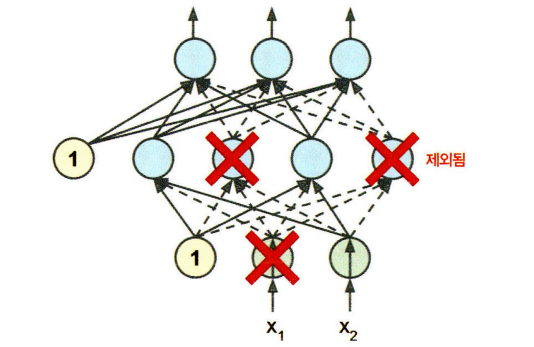

드롯아웃으로 훈련된 뉴런은 **이웃한 뉴런에 맞추어 적응될 수 없다.** 즉 가능한 자기 자신이 유용해져야 한다는 것을 의미한다. 또한 이런 뉴런들은 몇 개의 입력 뉴런에만 지나치게 의존할 수 없고 **모든 입력 뉴런에 주의를 기울여야 한다.** 그러므로 **입력값의 작은 변화에 덜 민감**해지며, 결국 **더 안정적인 네트워크가 되어 일반화 성능이 좋아진다.**

일반적으로 출력층을 제외한 **맨 위의 층부터 3번째 층까지 있는 뉴런에만 드롭아웃을 적용**한다.

드롭아웃 비율 p=50%으로 지정하면 테스트하는 동안 **하나의 뉴런이 훈련 때보다 평균적으로 2배 많은 입력 뉴런과 연결**된다. 이런 점을 보상하기 위해 훈련하고 나서 각 뉴런의 연결 가중치에 0.5를 곱할 필요가 있다. 그렇지 않으면 각 뉴런이 훈련한 것보다 거의 2배 많은 입력 신호를 받기 때문에 잘 작동하지 않을 것이다.

조금 더 일반화하자면 훈련이 끝난 뒤에 **각 입력의 연결 가중치에 보존 확률 $1-p$를 곱해야 한다.** 또는 훈련하는 동안 각 뉴런의 출력을 보존 확률로 나눌 수도 있다.

케라스에서는 **`keras.layers.Dropout`** 층을 사용하여 드롭아웃을 구현한다.

이 층은 **훈련하는 동안 일부 입력을 랜덤하게 버린다.** 즉 **0으로 설정**하는 것이다. 그 다음 **남은 입력을 보존 확률로 나눈다.** 최종적으로 훈련이 끝난 후에는 어떠한 작업도 하지 않으며, 입력을 그냥 다음 층으로 전달한다.

다음의 코드는 드롭아웃 비율을 0.2로 지정한 드롭아웃 규제를 모든 `Dense` 층 이전에 적용하는 것이다.

In [48]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [49]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [50]:
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5688 - accuracy: 0.8042 - val_loss: 0.3729 - val_accuracy: 0.8636
Epoch 2/2
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4250 - accuracy: 0.8441 - val_loss: 0.3589 - val_accuracy: 0.8682


**드롭아웃은 훈련하는 동안에만 활성화**되므로 훈련 손실과 검증 손실을 비교하면 오해를 일으키기 쉽다. 따라서 **훈련이 끝난 후에 드롭아웃을 빼고 훈련 손실을 평가**해야 한다.

만약 모델이 훈련 세트에 **과대적합**되었다면 **드롭아웃 비율을 늘릴 수 있다.** 반대로 모델이 훈련 세트에 **과소적합**되었다면 **드롭아웃 비율을 낮춰야 한다.**

**층이 클 때는 드롭아웃 비율을 늘리고, 작은 층에는 드롭아웃 비율을 낮추는 것**도 도움이 된다. 또한 많은 최신의 신경망 구조는 **마지막 은닉층 뒤에만 드롭아웃을 사용**하고 있다.

드롭아웃은 상당히 느리게 수렴하게 만드는 경향이 있지만, 적절하게 튜닝하면 훨씬 좋은 모델을 만들 수 있다.

### 11.4.3 몬테 카를로 드롭아웃
한 논문에서 드롭아웃을 사용해야 할 몇 가지 이유를 소개하며, 훈련된 드롭아웃 모델을 재훈련하거나 전혀 수정하지 않고 성능을 크게 향상시킬 수 있는 몬테 카를로 드롭아웃(MC 드롭아웃)이라는 강력한 기법이 소개되었다. 이 방법을 사용하면 모델의 불확실성을 더 잘 측정할 수 있으면서 쉽게 구현할 수 있다.

아래의 코드는 앞서 훈련한 드롭아웃 모델을 재훈련하지 않고 성능을 향상시키는 MC 드롭아웃을 구현하는 것이다.

**`training=True`**로 지정하여 **Dropout 층을 활성화**하고, 테스트 세트에서 100번의 예측을 만든다. 드롭아웃이 활성화되었기 때문에 예측이 모두 달라진다.

`predict()` 메서드는 샘플이 행이고 클래스가 열로 이루어진 행렬을 반환한다. 테스트 세트에 10000개의 샘플과 10개의 클래스가 있으므로 이 행렬의 크기는 [10000,10]이다. 이런 행렬을 100개 쌓았으므로 y_probas는 [100,10000,10] 크기의 행렬이다.

첫번째 차원인 axis=0을 기준으로 평균을 구하면 한번의 예측을 수행했을 때와 같은 [10000,10] 크기의 배열 y_proba를 얻게 된다.

드롭아웃으로 만든 예측을 평균하면 일반적으로 드롭아웃 없이 예측한 하나의 결과보다 더 안정적이다.

In [51]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

예를 들어 드롭아웃이 없는 상태로 패션 MNIST 테스트 세트에 있는 첫번째 샘플의 모델 예측을 확인한다. 모델은 거의 확실하게 이 이미지가 클래스 9에 속한다고 확신한다.

이제 드롭아웃을 활성화하여 만든 예측과 비교한다.

In [52]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 185ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.07, 0.  , 0.92]],
      dtype=float32)

In [53]:
np.round(y_probas[:7, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.39, 0.  , 0.58]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.58, 0.  , 0.41]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.02, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.08, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.24, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.18, 0.  , 0.61]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.1 , 0.  , 0.85]]],
      dtype=float32)

In [54]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.15, 0.  , 0.81]],
      dtype=float32)

In [55]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.854

간단히 말하자면 MC 드롭아웃은 드롭아웃 모델의 성능을 높여주고 더 정확한 불확실성 추정을 제공하는 방법이다. 물론 훈련하는 동안에는 일반적인 드롭아웃처럼 수행하기 때문에 규제처럼 작동한다.

### 11.4.4 맥스-노름 규제
신경망에서 널리 사용되는 또 다른 규제 기법으로 **맥스-노름 규제**가 있다. 이 방법은 각각의 뉴런에 대해 **입력의 연결 가중치 $𝐰$가 $∥𝐰∥_2≤r$이 되도록 제한**한다. 이때 $r$은 맥스-노름 하이퍼파라미터이고, $∥.∥_2$은 $l_2$ 노름을 나타낸다.

맥스-노름 규제는 전체 손실 함수에 규제 손실 항을 추가하지 않는다. 대신 일반적으로 **매 훈련 스텝이 끝나면 $∥𝐰∥_2$를 계산**하고, 필요하면 $𝐰←𝐰\frac{r}{∥𝐰∥_2}$으로 **$𝐰$의 스케일을 조정**한다. 이때 $r$를 줄이면 규제의 양이 증가하여 과대적합을 감소시키는데 도움이 된다.

맥스-노름 규제는 배치 정규화를 사용하지 않았을 때 불안정한 그래디언트 문제를 완화하는데 도움을 줄 수 있다.

케라스에서 맥스-노름 규제를 구현하기 위해서는 적절한 최댓값으로 지정한 **`max_norm()`이 반환한 객체로 은닉층의 `kernel_constraint` 매개변수를 지정**한다.



In [56]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

매 훈련 반복이 끝난 후에 모델의 `fit()` 메서드가 층의 가중치와 함께 `max_norm()`이 반환한 객체를 호출하고 스케일이 조정된 가중치를 반환받는다. 그리고 이 값을 사용하여 층의 가중치를 바꾼다.

`max_norm()` 함수는 기본값이 0인 `axis` 매개변수가 있다. `Dense` 층은 일반적으로 [샘플 개수, 뉴런 개수] 크기의 가중치를 갖는다. 이때 매개변수를 `axis=0`으로 지정하면 맥스-노름 규제는 각 뉴런의 가중치 벡터에 독립적으로 적용된다.